0624 금요일 과제 [필사]

# **1. [Baseline] 2. 전이학습(transfer learning)을 통한 이미지 분류**

In [3]:
#필요한 library 들을 load 합니다.
import os 
os.environ['CUDA_VISIBLE_DEVICES']='0' 

import random
import numpy as np
from tqdm import tqdm

import torch
from torchvision import datasets,models,transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from multiprocessing import cpu_count
from torch.utils.data import Dataset,DataLoader,SubsetRandomSampler
from torch.nn import CrossEntropyLoss
from torchvision.models import efficientnet_b3 as efficientnet
from sklearn.model_selection import train_test_split

### **데이터 load, 전처리**

In [4]:
transform = transforms.Compose([
                               transforms.ToTensor(), # 이미지 데이터를 tensor 데이터 포맷으로 바꾸어줍니다.
                               transforms.Resize([224,224]), # 이미지의 크기를 다를 수 있으니 크기를 통일해 줍니다.
                               transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)) # 픽셀 단위 데이터를 정규화
])

In [5]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
train_idx, valid_idx = train_test_split(np.arange(len(train_data)), test_size=0.2,
                                        random_state=42, shuffle=True, stratify=train_data.targets)

In [7]:
batch_size = 32 # 하드웨어에 한 번에 load 할 데이터의 크기
num_workers = int(cpu_count() / 2) # 데이터 로드 멀티 프로세싱을 위한 파라미터

* data loader 생성
    * 데이터 셋을 순회하며 모델에 데이터를 넣어주는 객체

In [8]:
train_loader = DataLoader(train_data, batch_size=batch_size,
                          sampler=SubsetRandomSampler(train_idx), num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size,
                          sampler=SubsetRandomSampler(valid_idx), num_workers=num_workers)

데이터 크기 확인

In [9]:
train_total = len(train_idx)
valid_total = len(valid_idx)

train_batches = len(train_loader)
valid_batches = len(valid_loader)

In [10]:
print('total train imgs :', train_total, '/ total train batches :', train_batches)
print('total valid imgs :', valid_total, '/ total valid batches :', valid_batches)

total train imgs : 40000 / total train batches : 1250
total valid imgs : 10000 / total valid batches : 313


### **Device 설정**

* gpu가 있다고 가정

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

### **모델 불러오기 / 파라미터 설정**

In [13]:
net = models.efficientnet_b3(pretrained=False)
net.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

* pretrained=False : 모델의 구조만 load(모델의 가중치는 load X)

In [14]:
net.fc = nn.Linear(1000, 10)
net = net.to(device)

파라미터 설정

In [15]:
criterion = CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)
epochs = 10

### **학습**

In [16]:
for epoch in range(epochs):
    net.train()

    train_loss = 0
    train_correct = 0 
    tqdm_dataset = tqdm(train_loader)
    for x,y in tqdm_dataset:
        x = x.to(device)
        y = y.to(device)
        outputs = net(x)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(y).sum().item()

        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(loss.item()),
        })

    train_loss = train_loss / train_batches
    train_acc = train_correct / train_total

    net.eval()

    valid_loss = 0
    valid_correct = 0 
    tqdm_dataset = tqdm(valid_loader)
    with torch.no_grad():
        for x,y in tqdm_dataset:
            x = x.to(device)
            y = y.to(device)
            
            outputs = net(x)
            loss = criterion(outputs, y)
            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            valid_correct += predicted.eq(y).sum().item()

            tqdm_dataset.set_postfix({
                'Epoch': epoch + 1,
                'Loss': '{:06f}'.format(loss.item()),
            })

    valid_loss = valid_loss / valid_batches
    valid_acc = valid_correct / valid_total

    print('epochs', epoch+1, 'train_loss', train_loss, 'train_acc', train_acc, 'valid loss', valid_loss, 'valid acc', valid_acc)


100%|██████████| 313/313 [00:32<00:00,  9.56it/s, Epoch=1, Loss=1.408500]


epochs 1 train_loss 1.7662172770500184 train_acc 0.35395 valid loss 1.374818274388298 valid acc 0.4942


100%|██████████| 313/313 [00:30<00:00, 10.34it/s, Epoch=2, Loss=0.717607]


epochs 2 train_loss 1.1875119799137115 train_acc 0.579225 valid loss 0.9287768513821184 valid acc 0.6764


100%|██████████| 313/313 [00:29<00:00, 10.66it/s, Epoch=3, Loss=0.786429]


epochs 3 train_loss 0.882630180478096 train_acc 0.693725 valid loss 0.7421915514019731 valid acc 0.7358


100%|██████████| 313/313 [00:29<00:00, 10.72it/s, Epoch=4, Loss=0.682562]


epochs 4 train_loss 0.7020350877165794 train_acc 0.757675 valid loss 0.6328152020613607 valid acc 0.7867


100%|██████████| 313/313 [00:30<00:00, 10.17it/s, Epoch=5, Loss=0.587647]


epochs 5 train_loss 0.5836062638580799 train_acc 0.7995 valid loss 0.5516336209381731 valid acc 0.8133


100%|██████████| 313/313 [00:29<00:00, 10.71it/s, Epoch=6, Loss=0.138969]


epochs 6 train_loss 0.5026429334819317 train_acc 0.829075 valid loss 0.49325499785974763 valid acc 0.8348


100%|██████████| 313/313 [00:29<00:00, 10.72it/s, Epoch=7, Loss=0.451814]


epochs 7 train_loss 0.42677490765452386 train_acc 0.855275 valid loss 0.4886115211457871 valid acc 0.8374


100%|██████████| 313/313 [00:29<00:00, 10.63it/s, Epoch=8, Loss=0.313571]


epochs 8 train_loss 0.3726479814350605 train_acc 0.8734 valid loss 0.46311127594389473 valid acc 0.8441


100%|██████████| 313/313 [00:29<00:00, 10.73it/s, Epoch=9, Loss=0.096346]


epochs 9 train_loss 0.328497914737463 train_acc 0.88745 valid loss 0.40547367028249337 valid acc 0.865


100%|██████████| 313/313 [00:29<00:00, 10.70it/s, Epoch=10, Loss=0.640466]

epochs 10 train_loss 0.28411451646387575 train_acc 0.901425 valid loss 0.44631458245241606 valid acc 0.8606


### **모델 저장 / 불러오기**

학습된 모델의 가중치 저장

In [22]:
path = './model.pth'
torch.save(net.state_dict(), path)

저장된 모델 불러오기

In [23]:
path = './model.pth'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

### **추론**

test 데이터 예측

In [24]:
from glob import glob
import PIL.Image
import numpy as np

test_images = []

path = './data/'
for filename in sorted(glob(path + 'test/*.jpg')):
    an_img = PIL.Image.open(filename)
    img_array = np.array(an_img)
    test_images.append(img_array)

test_images = np.array(test_images)

In [29]:
class CustomDataset(Dataset):
    def __init__(self, transform):
        self.transform = transform 
        self.img_list = test_images
        self.img_labels = [0] * 10000 

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.transform(self.img_list[idx]), self.img_labels[idx]

In [30]:
test_set = CustomDataset(transform)

In [31]:
test_loader = DataLoader(test_set, batch_size = batch_size, num_workers = num_workers)

* 이후의 코드는 sample_submission.csv를 다운 받을 수 없어서 실행하지 않음



```
import pandas as pd
sample_submission = pd.read_csv('sample_submission.csv')

net.eval() # 학습이 진행되지 않도록 함.

batch_index = 0

for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    outputs = net(images)
    batch_index = i * batch_size
    max_vals, max_indices = torch.max(outputs, 1)
    sample_submission.iloc[batch_index:batch_index + batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

```



예측된 데이터의 라벨은 숫자로 되어 있기 때문에, 제출을 위해 라벨 복원 과정 진행



```
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sample_submission['target'] = sample_submission['target'].map(labels)
```



# **2. 파이썬 딥러닝 텐서플로 CH4.4 (p.182-200)**

### **04 위성 이미지 분류**

### **4-1** 텐서플로 데이터셋 로드

In [32]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [33]:
# EuroSAT 위성 사진 데이터셋 로드

DATA_DTR = 'dataset/'

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,
                                       data_dir=DATA_DTR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incompleteCWUH9E/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


* ```with_info```
    * True: 메타 정보 불러오기
    * False: 메타 정보 없이 (훈련 셋, 검증 셋) 형태의 튜플로 반환


In [34]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

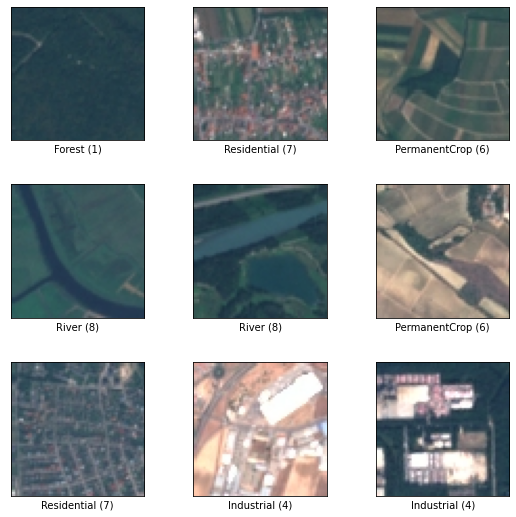

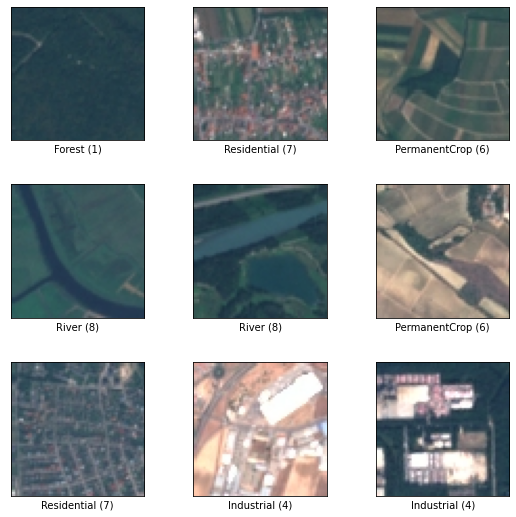

In [35]:
# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,9 (SeaLake)
1,,8 (River)
2,,9 (SeaLake)
3,,9 (SeaLake)
4,,9 (SeaLake)
5,,0 (AnnualCrop)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,0 (AnnualCrop)
9,,2 (HerbaceousVegetation)

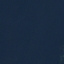
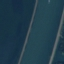
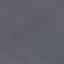
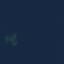
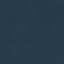
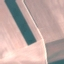
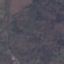
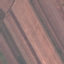
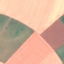
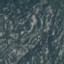

In [36]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [37]:
# 목표 클래스의 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


* 클래스 0: 경작지(AnnualCrop)
* 클래스 9: 바다/호수(SeaLake)

In [38]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features['label'].int2str(6))

PermanentCrop


* 클래스 6: 영구작물(PermanentCrop)

### **4-2** 데이터 전처리

* 텐서플로 연산은 float32 숫자 값을 사용하기 때문에 ```cast``` 함수로 float 32 변환
* 입력 이미지는 0~255 범위의 픽셀 값을 갖기 때문에 255로 나눠서 정규화. ```preprocess_data```를 정의하여 사용.
* ```num_parallel_calls``` 옵션을 오토튠으로 지정하여 텐서플로 병렬연산 처리를 자동으로 최적화 -> 빠른 속도로 처리 가능

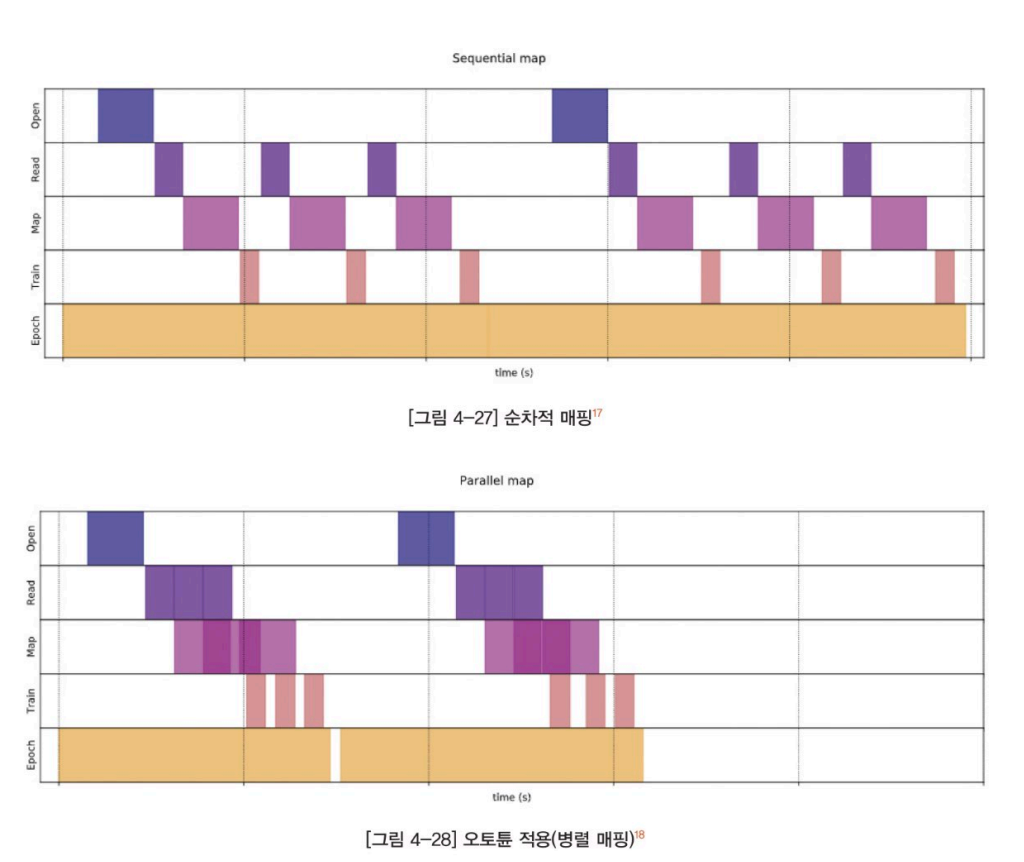

In [40]:
# 데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000 # 데이터셋 개수가 많거나 이미지 파일의 크기가 클 때 1000으로 지정하는 것이 일반적

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

* ```prefetch()```: 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와 미리 전처리를 함.

### **4-3** 모델 훈련 및 검증 

* 배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛 2개 연결
* Dense레이어와 Dropout으로 구성된 최종분류기를 갖는 딥러닝 모델을 Sequential API로 생성

In [43]:
# sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([
        # Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        
        # Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

예측 클래스 10개인 다중 분류 문제에 맞게 손실함수, 평가지표 설정, 50epoch 훈련

In [44]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 24s 31ms/step - loss: 1.4992 - accuracy: 0.4885 - val_loss: 1.6847 - val_accuracy: 0.4070
Epoch 2/50
338/338 [==============================] - 7s 20ms/step - loss: 1.1085 - accuracy: 0.6144 - val_loss: 0.7855 - val_accuracy: 0.7256
Epoch 3/50
338/338 [==============================] - 7s 20ms/step - loss: 0.8679 - accuracy: 0.7079 - val_loss: 0.6820 - val_accuracy: 0.7706
Epoch 4/50
338/338 [==============================] - 7s 20ms/step - loss: 0.7519 - accuracy: 0.7485 - val_loss: 0.5546 - val_accuracy: 0.8220
Epoch 5/50
338/338 [==============================] - 7s 21ms/step - loss: 0.6584 - accuracy: 0.7814 - val_loss: 0.5429 - val_accuracy: 0.8206
Epoch 6/50
338/338 [==============================] - 10s 29ms/step - loss: 0.5939 - accuracy: 0.8061 - val_loss: 0.4837 - val_accuracy: 0.8441
Epoch 7/50
338/338 [==============================] - 7s 20ms/step - loss: 0.5370 - accuracy: 0.8241 - val_loss: 0.5567 - val_accuracy: 0.81

In [46]:
# 손실함수, 정확도 그래프 그리기 

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

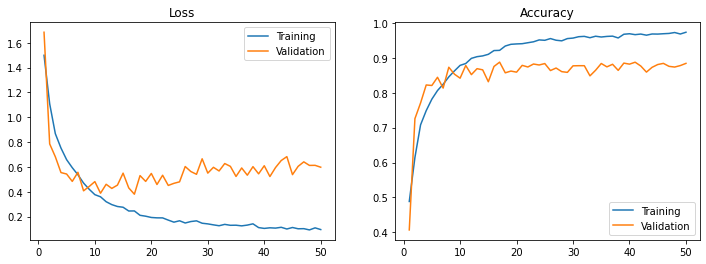

In [52]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 50)

* 10 epoch 까지 손실함수가 급격하게 감소
* 그 이후로 검증 셋에 대한 손실함수가 줄어들지 않으면서 과대 적합 경향 보임.

### **4-4** 데이터 증강(Data Augmentation)

**데이터 증강(Data Augmentation)**
* 이미지 분류 문제에서 과대 적합 해소하고, 모델의 일반화된 Robust한 성능을 확보하는 기법
* 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식, 새로운 데이터에 대한 모델의 예측력 강화 목적.

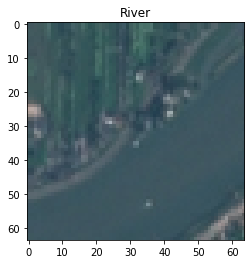

In [53]:
# 샘플 이미지 선택
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label));

In [54]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1,2, figsize=(12,4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

```flip_left_right```: 이미지 좌우 방향 반전

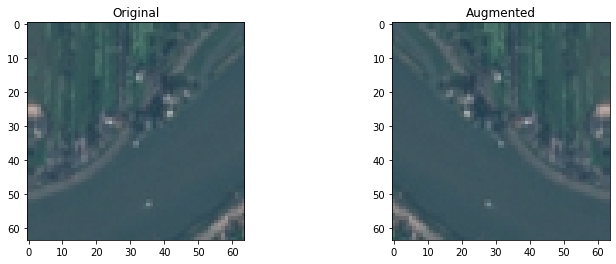

In [56]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

```flip_up_down```: 이미지 상하 방향 반전

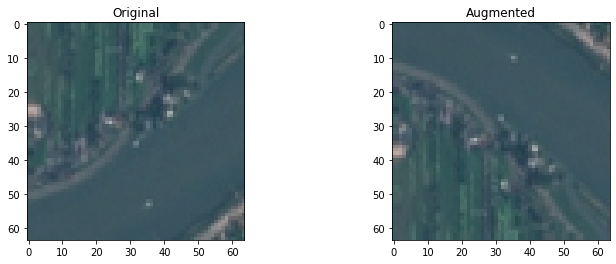

In [57]:
# 상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

```rot90```: 이미지 반시계 방향으로 90도 회전

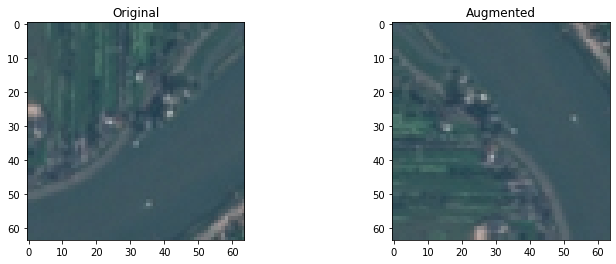

In [58]:
# 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

```transpose```: 이미지 행렬 도치

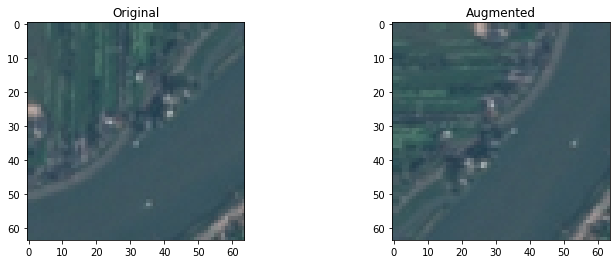

In [59]:
# transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

```central_crop```: 이미지 중심에서 일정 부분 잘라내기

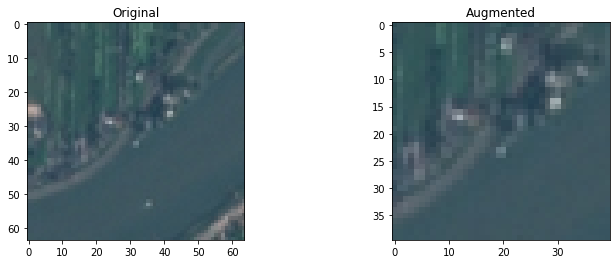

In [60]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction = 0.6)
plot_augmentation(image, crop1)

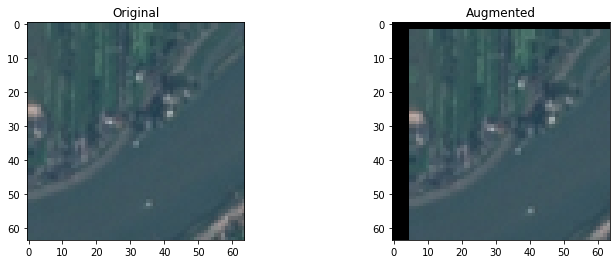

In [61]:
# 이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64,64,3])
plot_augmentation(image, crop2)

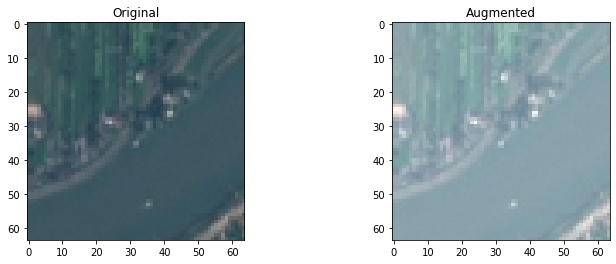

In [62]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

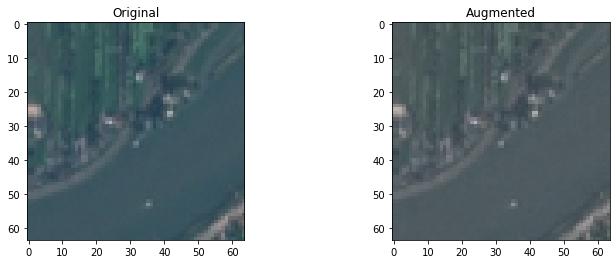

In [63]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

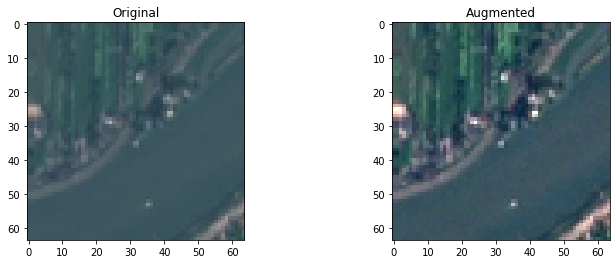

In [64]:
# 이미지 대비(contrast)
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [65]:
# 이미지 증강 전처리
def data_augmentation(image, label):

    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화
    image = tf.image.random_crop(image, size=[64,64,3])

    image = tf.cast(image, tf.float32) / 255. # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [66]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug,
                            validation_data=valid_aug,
                            epochs=50)

Epoch 1/50
338/338 [==============================] - 11s 30ms/step - loss: 1.9954 - accuracy: 0.2469 - val_loss: 1.8274 - val_accuracy: 0.3441
Epoch 2/50
338/338 [==============================] - 9s 25ms/step - loss: 1.7133 - accuracy: 0.3415 - val_loss: 1.4259 - val_accuracy: 0.4813
Epoch 3/50
338/338 [==============================] - 9s 24ms/step - loss: 1.5929 - accuracy: 0.3902 - val_loss: 1.2755 - val_accuracy: 0.5361
Epoch 4/50
338/338 [==============================] - 9s 25ms/step - loss: 1.4809 - accuracy: 0.4372 - val_loss: 1.2157 - val_accuracy: 0.5561
Epoch 5/50
338/338 [==============================] - 9s 25ms/step - loss: 1.3902 - accuracy: 0.4735 - val_loss: 1.1393 - val_accuracy: 0.5904
Epoch 6/50
338/338 [==============================] - 9s 25ms/step - loss: 1.3471 - accuracy: 0.5011 - val_loss: 1.1628 - val_accuracy: 0.6004
Epoch 7/50
338/338 [==============================] - 9s 25ms/step - loss: 1.2987 - accuracy: 0.5276 - val_loss: 1.0139 - val_accuracy: 0.668

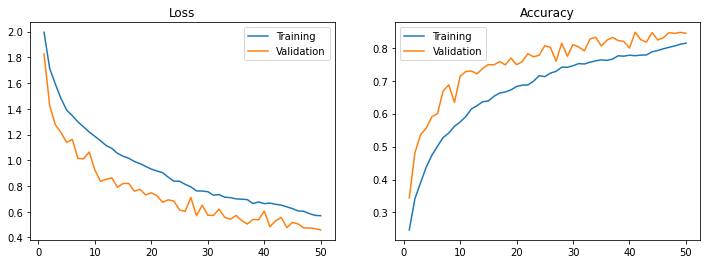

In [67]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 50)

### **4-5** ResNet 사전 학습 모델

**ResNet**: Kaiming He 등이 제안한 개념으로, 2015년 이미지넷 경진대회에서 3.6% 오분류율을 기록하며 우승한 모델. 152개의 깊은 층을 쌓는 방식으로 모델의 예측력을 높이면서도, skip connection 기법을 사용하여 경사소실 문제를 해결

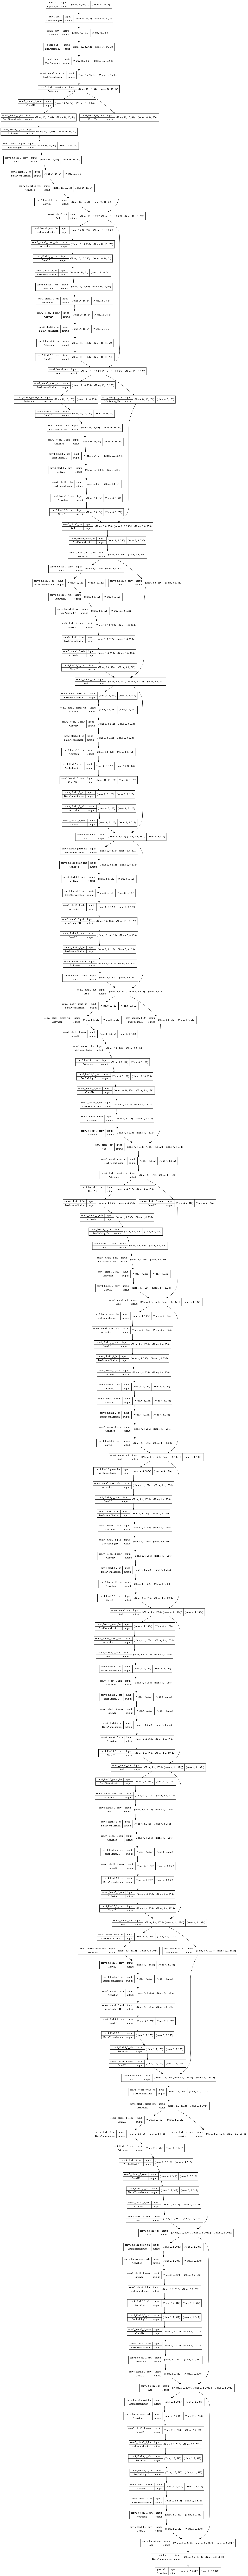

In [82]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2


pre_trained_base = ResNet50V2(include_top=False, # 기존 Top층 제거
                              weights='imagenet',
                              input_shape=[64,64,3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True)

In [83]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

    model = tf.keras.Sequential([
            # Pre-trained Base
            pre_trained_base,
            # Classifier 출력층
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 10)               

* resnet50v2 모델의 파라미터 23,564,800개는 훈련이 되지 않는 것으로 확인.
* Top 층에 추가한 Dense레이어들의 파라미터만 가중치 업데이트